In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from collections import deque
import random

import logging

2023-07-21 14:41:49.102824: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 14:41:49.195032: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 14:41:49.196945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 14:41:50.813783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the Q-Network model
def create_q_network(input_shape, action_space):
    model = Sequential(
        [
            tf.keras.Input(shape=input_shape),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(action_space, activation='linear')
        ]
    )
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.005))
    return model

In [3]:
class ENV():
    def __init__(self):
        self.steps = 0
        self.env_col = 6
        self.env_row = 6
        self.state = (5, 5)
        self.action_space = 4
        self.reward = 0
        self.done = False
        self.goal = [(1, 1),(4,5)]

    def reset(self,i):
        self.goal_x = self.goal[i]
        self.state = np.random.randint(0, min(self.env_col, self.env_row), size=2)
        self.reward = 0
        self.done = False
        self.steps = 0
        return self.state, self.goal_x

    def step(self, action):
        self.steps += 1
        prev_state = list(self.state).copy()
        if action == 0 and self.state[1] < self.env_row - 1: # up
            self.state = (self.state[0], self.state[1] + 1)
        elif action == 1 and self.state[1] > 0: # down
            self.state = (self.state[0], self.state[1] - 1)
        elif action == 2 and self.state[0] > 0: # left
            self.state = (self.state[0] - 1, self.state[1])
        elif action == 3 and self.state[0] < self.env_col - 1: # right
            self.state = (self.state[0] + 1, self.state[1])
        else:
            pass
            # raise ValueError("Invalid action")
        if self.state[0] == self.goal_x[0] and self.state[1] == self.goal_x[1]:
            self.reward = 100
            self.done = True
        elif self.state[0] < 0 or self.state[0] >= self.env_col or self.state[1] < 0 or self.state[1] >= self.env_row:
            self.reward = -100
            self.done = True
        elif self.steps >= 50:
            self.reward = 0
            self.done = True
        else:
          if self.euclidean_distance_from_goal(self.state) < self.euclidean_distance_from_goal(prev_state):
            self.reward = 1
          else:
            self.reward = -1
        return self.state, self.reward, self.done

    def euclidean_distance_from_goal(self, pos):
        # calculate the distance between the current position and the goal
        dist = np.sqrt((pos[0] - self.goal_x[0]) ** 2 + (pos[1] - self.goal_x[1]) ** 2)
        return dist


In [4]:
#Define the DQN agent
class DQNAgent:
    def __init__(self, state_shape, action_space):
        self.state_shape = state_shape
        self.action_space = action_space
        self.memory = deque(maxlen=1000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.model = create_q_network(state_shape, action_space)

        self.target_model = create_q_network(state_shape, action_space)
        self.target_model.set_weights(self.model.get_weights())


    def clear_buffer(self):
        # self.memory = []
        self.epsilon = 1
        self.memory = deque(maxlen=1000)

    def remember(self, state,input, goal, action, reward, next_state, done):
        self.memory.append((state, input, goal,  action, reward, next_state, done))

    def act(self, input):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        # print("state in action: ",state)

        input = np.reshape(input, 4)
        input = tf.convert_to_tensor(input)
        input = tf.expand_dims(input, 0)

        # print("Predicting")
        q_values = self.model.predict(input, verbose=0)
        # print("q_value: from act function ", q_values)
        return np.argmax(q_values[0])


    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        # Debug
        # print(self.memory)
        # batch = np.random.choice(self.memory, batch_size, replace=False)
        batch_ch = np.random.choice(len(self.memory), batch_size, replace=False)
        batch = [self.memory[i] for i in batch_ch]
        for state, input, goal, action, reward, next_state, done in batch:
            state = np.reshape(state, 2)
            next_state = np.reshape(next_state, 2)
            target = reward
            # print("the target -- REWARD: ", target)
            input_2 = []
            input_2.append(next_state)
            input_2.append(goal)
            input_2 = np.reshape(input_2, 4)
            # print("printing input_2: ",input_2)
            if not done:
                # print(next_state.shape)
                input_2 = tf.convert_to_tensor(input_2)
                input_2 = tf.expand_dims(input_2, 0)
                target = reward + self.gamma * np.amax(self.target_model.predict(input_2, verbose=0)[0])
                # print("reward for that step: ", target)

            # print(state.shape)
            input = tf.convert_to_tensor(input)
            input = tf.expand_dims(input, 0)
            # print("Predicting")
            target_f = self.model.predict(input, verbose=0)
            # print("target_f: ", target_f)
            target_f[0][action] = target
            # print("target_f[0][action]: ",target_f[0][action])
            # print(state[0], state[1])
            # print("Fitting model")
            self.model.fit(input, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            # print("epsilon for this episode is: ", self.epsilon)
            logging.info(f"Epsilon: {self.epsilon}")


In [5]:
# Initialize the environment and agent
state_shape = (4,)  # Example state shape, adjust according to your actual state representation # Only x and y coordinates
action_space = 4  # Example action space size, adjust according to your actual actions # 4 actions: up, down, left, right
agent = DQNAgent(state_shape, action_space)
env = ENV()


In [6]:
#Training loop
num_episodes = 1000  # Set the number of training episodes
batch_size = 32  # Set the batch size for replay
total_reward = []
i=0

# epsilon_start = 1.0
# epsilon_end = 0.1
# epsilon_decay_steps = 1000

# Create a summary writer for logging
# summary_writer = tf.summary.create_file_writer("logs")


for episode in range(num_episodes):
    print("Episode: ", episode)
    # if episode%300 == 0:
    #     agent.clear_buffer()
    #     env = ENV()
    #     i+=1
    input = []
    # print("IM RESETTING START POINT !!!!!!!!!!!!!!!!!")
    state, goal = env.reset(i)
    input.append(state)
    input.append(goal)
    # print("prinintg concat: ", input)

    input = np.reshape(input, 4)
    # print("printing input ", input)
    state = np.reshape(state, 2)
    goal = np.reshape(goal, 2)
    # print("prininting state and goal ", state, goal)
    done = False
    episode_reward = 0
    if episode%50 == 0 and episode != 0 :
        agent.model.save("model_dqn_diff_start_diff_goal_{}.h5".format(episode))
    while not done:
        action = agent.act(input)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, 2)
        # print("printing GOAL: ", goal)
        agent.remember(state, input ,goal, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        # if len(agent.memory) > batch_size:
        #     agent.replay(batch_size)

    agent.replay(batch_size)

    agent.update_target_network()



    # Decay epsilon for epsilon-greedy exploration
    # epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay_steps)
    # print("EPSILON DECAY VALUE: ", epsilon)

    print("EPISODE {} REWARD {}".format(episode, episode_reward))
    # with tf.summary.record_if(True):
    #         print("<<<<<<<<<<<<<<<<<<<<<<<<< inside tensorboard >>>>>>>>>>>>>>>>>>>>>>> ")
    #         tf.summary.scalar("Total_Reward", episode_reward, step=episode)

    # agent.target_model.set_weights(agent.model.get_weights())
    # the above line is WRONG !!!!!!!!!!!!!!
    total_reward.append(episode_reward)


Episode:  0
EPISODE 0 REWARD 99
Episode:  1
EPISODE 1 REWARD 98
Episode:  2
EPISODE 2 REWARD -3
Episode:  3
EPISODE 3 REWARD 98
Episode:  4
EPISODE 4 REWARD 102
Episode:  5
EPISODE 5 REWARD -11
Episode:  6
EPISODE 6 REWARD 100
Episode:  7
EPISODE 7 REWARD -7
Episode:  8
EPISODE 8 REWARD -11
Episode:  9
EPISODE 9 REWARD -9
Episode:  10
EPISODE 10 REWARD 93
Episode:  11
EPISODE 11 REWARD -13
Episode:  12
EPISODE 12 REWARD -5
Episode:  13
EPISODE 13 REWARD -7
Episode:  14
EPISODE 14 REWARD 101
Episode:  15
EPISODE 15 REWARD 101
Episode:  16
EPISODE 16 REWARD -9
Episode:  17
EPISODE 17 REWARD -7
Episode:  18
EPISODE 18 REWARD 96
Episode:  19
EPISODE 19 REWARD 101
Episode:  20
EPISODE 20 REWARD 97
Episode:  21
EPISODE 21 REWARD -11
Episode:  22
EPISODE 22 REWARD -15
Episode:  23
EPISODE 23 REWARD -7
Episode:  24
EPISODE 24 REWARD 95
Episode:  25
EPISODE 25 REWARD 94
Episode:  26
EPISODE 26 REWARD 92
Episode:  27
EPISODE 27 REWARD 103
Episode:  28
EPISODE 28 REWARD -13
Episode:  29
EPISODE 2

2023-07-21 15:05:23.302073: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled


EPISODE 253 REWARD -35
Episode:  254
EPISODE 254 REWARD -31
Episode:  255
EPISODE 255 REWARD 100
Episode:  256
EPISODE 256 REWARD -37
Episode:  257
EPISODE 257 REWARD -35
Episode:  258
EPISODE 258 REWARD -31
Episode:  259
EPISODE 259 REWARD 100
Episode:  260
EPISODE 260 REWARD 102
Episode:  261
EPISODE 261 REWARD -27
Episode:  262
EPISODE 262 REWARD -31
Episode:  263
EPISODE 263 REWARD -31
Episode:  264
EPISODE 264 REWARD -35
Episode:  265
EPISODE 265 REWARD -35
Episode:  266
EPISODE 266 REWARD -31
Episode:  267
EPISODE 267 REWARD -45
Episode:  268
EPISODE 268 REWARD 92
Episode:  269
EPISODE 269 REWARD 81
Episode:  270
EPISODE 270 REWARD 80
Episode:  271
EPISODE 271 REWARD -45
Episode:  272
EPISODE 272 REWARD -43
Episode:  273
EPISODE 273 REWARD 100
Episode:  274
EPISODE 274 REWARD -37
Episode:  275
EPISODE 275 REWARD -33
Episode:  276
EPISODE 276 REWARD -35
Episode:  277
EPISODE 277 REWARD 101
Episode:  278
EPISODE 278 REWARD -39
Episode:  279
EPISODE 279 REWARD -41
Episode:  280
EPIS

KeyboardInterrupt: 

In [7]:
agent.model.save("one_model_all_1_grid_6_6.h5")

#FOR TESTING NOT UPDATED YET

In [ ]:
# Initialize the environment and agent
state_shape = (4,)  # Example state shape, adjust according to your actual state representation # Only x and y coordinates
action_space = 4  # Example action space size, adjust according to your actual actions # 4 actions: up, down, left, right
agent = DQNAgent(state_shape, action_space)
env = ENV()


In [ ]:
def act(self, input):
        if np.random.rand() < 0.9:
            return np.random.choice(4)
        # print("state in action: ",state)

        input = np.reshape(input, 4)
        input = tf.convert_to_tensor(input)
        input = tf.expand_dims(input, 0)

        print("Predicting")
        q_values = self.model.predict(input)
        return np.argmax(q_values[0])

In [ ]:
# Use the trained agent to control the agent in the environment
state, goal = env.reset(0)
print("goal: ", goal)
print("state: ", state)
# model = load_model('model_dqn_diff_start_diff_goal_0.h5')
agent.model = load_model('one_model_all_1_grid_6_6.h5')

done = False

while not done:
    input = []
    input.append(state)
    input.append(goal)
    # print("prinintg concat: ", input)
    input = np.reshape(input, 4)
    action = agent.act(input)
    next_state, _, done = env.step(action)
    next_state = np.reshape(next_state,2)
    input_2 = []
    input_2.append(next_state)
    input_2.append(goal)
    input_2 = np.reshape(input_2, 4)
    # Take action with the agent in the environment
    state = next_state
    print(state)

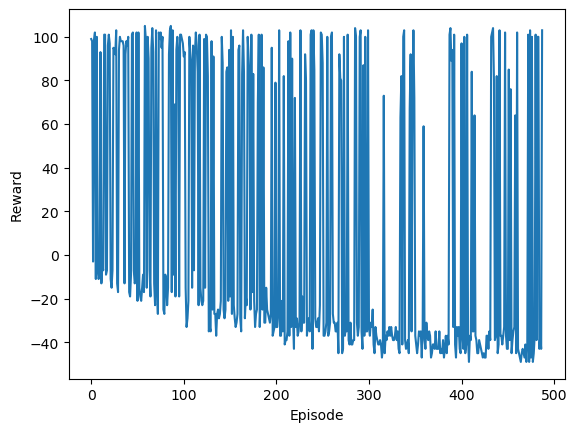

In [8]:
import matplotlib.pyplot as plt
plt.plot(total_reward)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

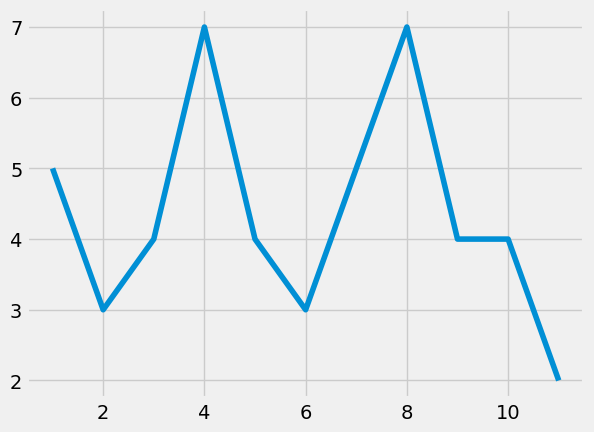

In [17]:
# live plot using matplotlib animation module for random values
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

style.use('fivethirtyeight')

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    graph_data = open('example.txt','r').read()
    lines = graph_data.split('\n')
    xs = []
    ys = []
    for line in lines:
        if len(line) > 1:
            x, y = line.split(',')
            xs.append(float(x))
            ys.append(float(y))

        # time.sleep(1)

    ax1.clear()
    ax1.plot(xs, ys)

# animate slowly
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()


In [15]:
from collections import deque
import random

In [16]:
memory = deque(maxlen=10)

In [ ]:
for i in range(21):
  memory.append((random.randint(1,10),random.randint(1,2),random.randint(1,4)))

In [ ]:
print(memory)

In [ ]:
batch = random.sample(memory, 5)
print(batch)

In [ ]:
print(memory)

#REAL TESTING

In [ ]:
class ENV_test():
    def __init__(self):
        self.steps = 0
        self.env_col = 6
        self.env_row = 6
        self.state = (5, 5)
        self.action_space = 4
        self.reward = 0
        self.done = False
        self.goal = (1, 1)

    def reset(self):
        self.goal_x = self.goal
        self.state = np.random.randint(0, min(self.env_col, self.env_row), size=2)
        self.reward = 0
        self.done = False
        self.steps = 0
        return self.state, self.goal_x

    def step(self, action):
        self.steps += 1
        if action == 0: # up
            self.state = (self.state[0], self.state[1] + 1)
        elif action == 1: # down
            self.state = (self.state[0], self.state[1] - 1)
        elif action == 2: # left
            self.state = (self.state[0] - 1, self.state[1])
        elif action == 3: # right
            self.state = (self.state[0] + 1, self.state[1])
        else:
            raise ValueError("Invalid action")
        if self.state == self.goal_x:
            self.reward = 100
            self.done = True
        elif self.state[0] < 0 or self.state[0] >= self.env_col or self.state[1] < 0 or self.state[1] >= self.env_row:
            self.reward = -100
            self.done = True
        elif self.steps >= 50:
            self.reward = -100
            self.done = True
        else:
            self.reward = -1
        return self.state, self.reward, self.done


In [ ]:
#Define the DQN agent
class DQNAgent_test:
    def __init__(self, state_shape, action_space):
        self.state_shape = state_shape
        self.action_space = action_space
        self.memory = []
        self.gamma = 0.95  # Discount factor
        self.epsilon = 0.9  # Exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.model = load_model('/content/model_dqn_diff_start_diff_goal_110.h5')


    def act(self, input):

        input = np.reshape(input, 4)
        input = tf.convert_to_tensor(input)
        input = tf.expand_dims(input, 0)

        # print("Predicting")
        q_values = self.model.predict(input, verbose=0)
        # print("q_value: from act function ", q_values)
        return np.argmax(q_values[0])


In [ ]:
# Initialize the environment and agent
state_shape = (4,)  # Example state shape, adjust according to your actual state representation # Only x and y coordinates
action_space = 4  # Example action space size, adjust according to your actual actions # 4 actions: up, down, left, right
agent = DQNAgent_test(state_shape, action_space)
env = ENV_test()


In [ ]:
# Use the trained agent to control the agent in the environment
state, goal = env.reset()
# state = [2,3]
print("goal: ", goal)
print("state: ", state)
done = False

while not done:
    input = []
    input.append(state)
    input.append(goal)
    # print("prinintg concat: ", input)
    input = np.reshape(input, 4)
    action = agent.act(input)
    next_state, _, done = env.step(action)
    next_state = np.reshape(next_state, 2)
    input_2 = []
    input_2.append(next_state)
    input_2.append(goal)
    input_2 = np.reshape(input_2, 4)
    # Take action with the agent in the environment
    state = next_state
    print(state)